# <div style="text-align: center"> Recurrent Neural Networks (RNN)</div>
#### <div style="text-align: right"> 2019.09.23 Monday</div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Jaewoong Cho, Junhyung Ahn</div>

**실습목표**
- Simple RNN 생성하기
- RNN을 훈련하여 시계열 예측하기 
- Long Short-Term Memory (LSTM)
- LSTM을 훈련하여 문장의 다음 글자 예측하기

In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import backend as K

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## 1-A. BasicRNNCell 함수 사용하여 RNN 생성하기

In [6]:
# h0 = y0
n_steps = 1
input_dim= 3
output_dim = 5

X = tf.placeholder(tf.float32, [None,input_dim])


with tf.variable_scope("static_rnn1", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_dim)
    outputs, states = tf.nn.static_rnn(cell=basic_cell, 
                                       inputs=[X], 
                                       dtype=tf.float32,)

X_batch  = np.array([[0,1,2],    
                     [3,4,5],    
                     [6,7,8],    
                     [9,0,1]])    

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    init.run()
    output_vals, states_val = sess.run([outputs, states], 
                                       feed_dict= {X: X_batch})

print("Output: \n {} \n".format(output_vals))
print("States: \n {}\n".format(states_val))
print("Output == States? \n {}".format(output_vals==states_val))

Output: 
 [array([[ 0.75263786,  0.2549876 ,  0.6432549 ,  0.88935304, -0.75778127],
       [ 0.99823064, -0.83952594, -0.46472752,  0.9793129 , -0.9095983 ],
       [ 0.999989  , -0.99100506, -0.94364816,  0.9962763 , -0.96799266],
       [ 0.83088094, -0.9963645 , -0.9998024 , -0.9978991 ,  0.99995214]],
      dtype=float32)] 

States: 
 [[ 0.75263786  0.2549876   0.6432549   0.88935304 -0.75778127]
 [ 0.99823064 -0.83952594 -0.46472752  0.9793129  -0.9095983 ]
 [ 0.999989   -0.99100506 -0.94364816  0.9962763  -0.96799266]
 [ 0.83088094 -0.9963645  -0.9998024  -0.9978991   0.99995214]]

Output == States? 
 [[[ True  True  True  True  True]
  [ True  True  True  True  True]
  [ True  True  True  True  True]
  [ True  True  True  True  True]]]


In [7]:
# 정적으로 타임 스텝 펼치기
X0 = tf.placeholder(tf.float32, [None, input_dim])
X1 =  tf.placeholder(tf.float32, [None, input_dim])

# 미니배치
X0_batch = np.array([[0,1,2],
                     [3,4,5],
                     [6,7,8],
                     [9,0,1]]) #t=0
X1_batch = np.array([[9,8,7],
                     [0,0,0],
                     [6,5,4],
                     [3,2,1]]) #t=1

with tf.variable_scope("static_rnn2", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_dim)
    output_seqs, states = tf.contrib.rnn.static_rnn(cell=basic_cell,
                                                    inputs=[X0,X1],
                                                    dtype=tf.float32)
    Y0,Y1 = output_seqs

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    Y0_val, Y1_val = sess.run([Y0,Y1], feed_dict={X0: X0_batch, X1:X1_batch})
    state_val = sess.run(states, feed_dict={X0: X0_batch, X1:X1_batch})
    
print("Y0_val: \n{}".format(Y0_val))      # t=0에서 y 
print("Y1_val: \n{}".format(Y1_val))      # t=1에서 y 
print("State_val: \n{}".format(state_val)) # t=1에서의 h

Y0_val: 
[[ 0.7757696  -0.18567282  0.10213619 -0.3647488   0.6396898 ]
 [ 0.9506891   0.9414699   0.98415405  0.58706707 -0.23478928]
 [ 0.98992974  0.99875236  0.9998434   0.93890333 -0.8443548 ]
 [-0.97309005  0.9998412   0.99993825  0.9924921  -0.99953246]]
Y1_val: 
[[ 0.6442961   0.9999914   0.9999994   0.9989242  -0.9989959 ]
 [-0.8275744   0.93475366  0.56923896  0.4233291  -0.5209866 ]
 [-0.49106044  0.99998873  0.99994254  0.9924001  -0.99811655]
 [-0.04610159  0.99433315  0.95029104  0.914551   -0.9630546 ]]
State_val: 
[[ 0.6442961   0.9999914   0.9999994   0.9989242  -0.9989959 ]
 [-0.8275744   0.93475366  0.56923896  0.4233291  -0.5209866 ]
 [-0.49106044  0.99998873  0.99994254  0.9924001  -0.99811655]
 [-0.04610159  0.99433315  0.95029104  0.914551   -0.9630546 ]]


In [9]:
# 가변 길이 시퀀스 입력
n_steps = 2

X = tf.placeholder(tf.float32, [None, n_steps, input_dim])
seq_length  = tf.placeholder(tf.int32, [None])
with tf.variable_scope("dynamic_rnn", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_dim)
    outputs, states = tf.nn.dynamic_rnn(cell=basic_cell, 
                                        inputs=X, 
                                        dtype=tf.float32,
                                        sequence_length=seq_length)

X_batch  = np.array([
                     # t = 0  # t = 1      
                     [[0,1,2],[9,8,7]],    # 샘플 0
                     [[3,4,5],[10,10,10]], # 샘플 1
                     [[6,7,8],[6,5,4]],    # 샘플 2
                     [[9,0,1],[3,2,1]]])   # 샘플 3

seq_length_batch = np.array([2,1,2,2])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    init.run()
    output_vals, states_val = sess.run([outputs,states], 
                                       feed_dict={X:X_batch, 
                                                  seq_length:seq_length_batch})
    
print("Output: \n {} \n".format(output_vals))
print("States: \n {}".format(states_val))

Output: 
 [[[ 0.7995446  -0.19910215  0.8454795  -0.5865879  -0.8807917 ]
  [ 0.6314698  -0.99830294  1.         -0.9475772  -0.9999998 ]]

 [[ 0.8790074  -0.9105236   0.99990505 -0.8829515  -0.99967223]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.9282266  -0.9934537   1.         -0.9707739  -0.9999991 ]
  [ 0.72306895 -0.9444617   0.99999785 -0.69367266 -0.9999432 ]]

 [[-0.99739194 -0.00743822  0.9999948   0.9966025  -0.9929053 ]
  [-0.8355269  -0.8894046   0.9824948  -0.0399096  -0.9067747 ]]] 

States: 
 [[ 0.6314698  -0.99830294  1.         -0.9475772  -0.9999998 ]
 [ 0.8790074  -0.9105236   0.99990505 -0.8829515  -0.99967223]
 [ 0.72306895 -0.9444617   0.99999785 -0.69367266 -0.9999432 ]
 [-0.8355269  -0.8894046   0.9824948  -0.0399096  -0.9067747 ]]


## 1-B. 시계열 예측을 위해 훈련하기

## 1) Dataset
- generate synthetic data

In [12]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) 
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  
    return np.expand_dims(series,2)

In [13]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

In [14]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [15]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

## 2) Functions

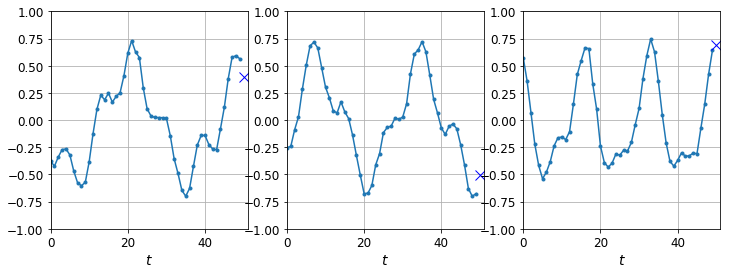

In [27]:
# Synthetic data plotting하기
def plot_series(series, 
                y=None, 
                y_pred=None):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10, label='Actual')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro",label='Prediction')
    plt.grid(True)
    plt.xlabel("$t$")
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1,
                         ncols=3, 
                         figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0])
plt.show()

In [29]:
# Loss curve plotting하기
def plot_loss_curves(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history["loss"], label="Training loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## 3) Models

### (1) Simple RNN

In [ ]:
simple_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

###  (2) LSTM

In [ ]:
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(units=20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

## 4) Training

### (1) Simple RNN 훈련하기

In [28]:
simple_rnn_model.compile(loss="mse", optimizer="adam")
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=20, 
                     validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 327us/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2/20
7000/7000 [==============================] - 2s 279us/sample - loss: 0.0053 - val_loss: 0.0045
Epoch 3/20
7000/7000 [==============================] - 2s 280us/sample - loss: 0.0043 - val_loss: 0.0038
Epoch 4/20
7000/7000 [==============================] - 2s 253us/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 5/20
7000/7000 [==============================] - 2s 252us/sample - loss: 0.0036 - val_loss: 0.0033
Epoch 6/20
7000/7000 [==============================] - 2s 252us/sample - loss: 0.0034 - val_loss: 0.0032
Epoch 7/20
7000/7000 [==============================] - 2s 271us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 8/20
7000/7000 [==============================] - 2s 251us/sample - loss: 0.0033 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 2s 246us/sample - loss: 0.0033 - val_loss: 0.003

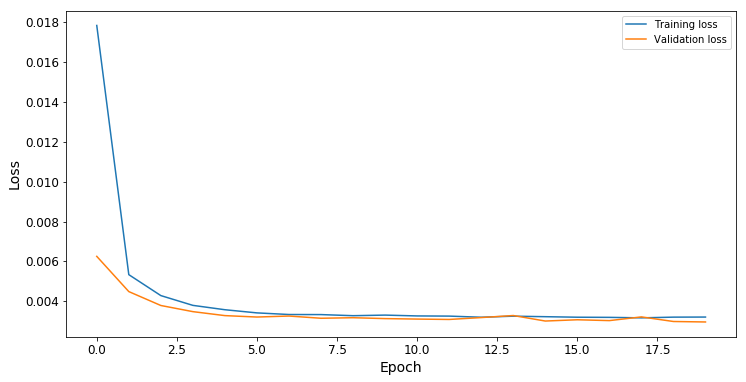

In [30]:
plot_loss_curves(simple_rnn_history)

In [31]:
simple_rnn_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 68us/sample - loss: 0.0031


0.0031279194317758085

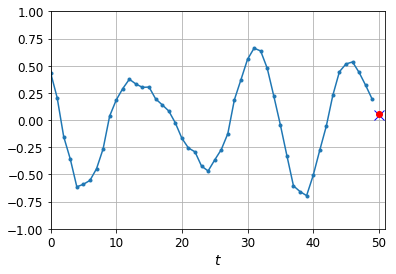

In [32]:
simple_rnn_y_pred = simple_rnn_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], simple_rnn_y_pred[0, 0])
plt.show()

In [33]:
print("Simple RNN Error: {}".format(y_test[0,0] - simple_rnn_y_pred[0,0]))

Simple RNN Error: -0.012018279337368015


### (2) LSTM 훈련하기

In [44]:
lstm_model.compile(loss="mse", optimizer="adam")
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0381 - val_loss: 0.0208
Epoch 2/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0126 - val_loss: 0.0075
Epoch 3/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0049 - val_loss: 0.0039
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0040 - val_loss: 0.0036
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0038 - val_loss: 0.0034
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0035 - val_loss: 0.0037
Epoch 7/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0033 - val_loss: 0.0030
Epoch 8/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 9/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 10/20
7000

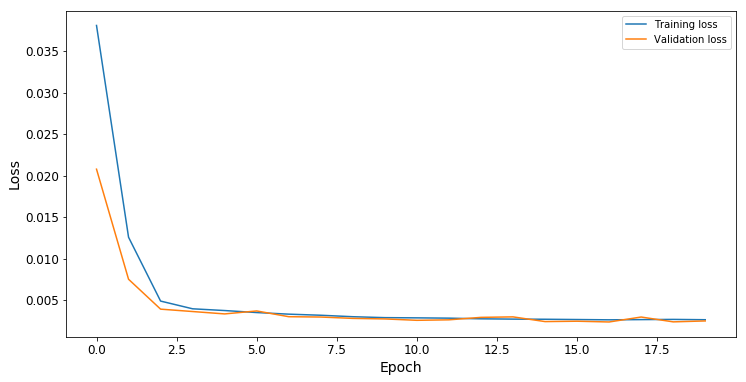

In [45]:
plot_loss_curves(lstm_history)

In [46]:
lstm_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 150us/sample - loss: 0.0027


0.0027121321950107813

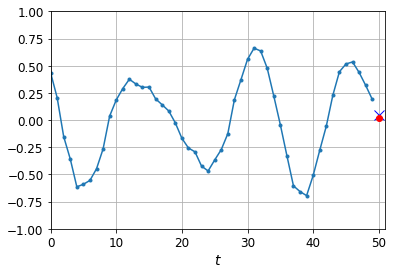

In [47]:
lstm_y_pred = lstm_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], lstm_y_pred[0, 0])
plt.show()

In [48]:
print("LSTM Error: {}".format(y_test[0,0] - lstm_y_pred[0,0]))

LSTM Error: 0.027812828144946095


## 1-C. LSTM 이용하여 다음 글자 예측하기

In [72]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()
    

In [73]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [77]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [78]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [79]:
max_id = len(tokenizer.word_index) 
dataset_size = tokenizer.document_count 

In [83]:
max_id,dataset_size

(39, 1115394)

In [82]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 1 // 100

In [96]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [97]:
print(dataset)

<DatasetV1Adapter shapes: (), types: tf.int64>


In [85]:
n_steps = 100
window_length = n_steps + 1 
dataset = dataset.repeat().window(window_length, shift=1, 
                                  drop_remainder=True)

In [86]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [87]:
np.random.seed(42)

In [94]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

<DatasetV1Adapter shapes: ((?, ?, ?, 39), (?, ?, ?)), types: (tf.float32, tf.int64)>


In [ ]:
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [89]:
dataset = dataset.map(lambda X_batch, Y_batch: 
                      (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [90]:
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, dropout=0.5, return_sequences=True, 
                      input_shape=[None, max_id]),
    keras.layers.LSTM(20, dropout=0.5, return_sequences=True),
    keras.layers.Dense(max_id, activation="softmax")
])

lstm_model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam")
lstm_history = lstm_model.fit(dataset, 
                    steps_per_epoch=train_size // batch_size, 
                    epochs=10)

Epoch 1/10
348/348 [==============================] - 49s 142ms/step - loss: 3.1400
Epoch 2/10
348/348 [==============================] - 47s 136ms/step - loss: 2.9750
Epoch 3/10
348/348 [==============================] - 48s 137ms/step - loss: 2.8325
Epoch 4/10
348/348 [==============================] - 47s 136ms/step - loss: 2.7269
Epoch 5/10
348/348 [==============================] - 46s 133ms/step - loss: 2.6523
Epoch 6/10
348/348 [==============================] - 46s 132ms/step - loss: 2.5851
Epoch 7/10
348/348 [==============================] - 47s 135ms/step - loss: 2.5361
Epoch 8/10
348/348 [==============================] - 47s 135ms/step - loss: 2.4960
Epoch 9/10
348/348 [==============================] - 47s 136ms/step - loss: 2.4680
Epoch 10/10
348/348 [==============================] - 46s 132ms/step - loss: 2.4427


In [91]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [102]:
X_new = preprocess(["How are yo"])
sess = tf.Session()
with sess.as_default():
    X_new = X_new.eval()

In [105]:
lstm_Y_pred = lstm_model.predict_classes(X_new)
tokenizer.sequences_to_texts(lstm_Y_pred + 1)[0][-1]

'u'